In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

In [2]:
from general_functions import *

In [3]:
pd.set_option('display.max_columns', None)


# WSRL

In [4]:
#define relative paths
waterschap = 'WSRL'
data_path = "../../Data_preprocessed/Waterschappen/WSRL"
output_gpkg_path = "../../Data_postprocessed/Waterschappen/WSRL"

In [5]:
#WSRL has delivered the data per catchment. Loop through each catchment, and concat all data to a single dictionary
WSRL = {}

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.gpkg'):
            gpkg_path = os.path.join(root, file)
            
            if WSRL == {}:
                WSRL = read_gpkg_layers(gpkg_path = gpkg_path,
                                         variables = ['Stuw',
                                                      'Gemaal',
                                                      'Hydroobject',
                                                      'Duikersifonhevel'])   
            else:
                temp_WSRL = read_gpkg_layers(gpkg_path = gpkg_path,
                                             variables = ['Stuw',
                                                          'Gemaal',
                                                          'Hydroobject',
                                                          'Duikersifonhevel'])   
                for variable in WSRL.keys():
                    WSRL[variable] = pd.concat([WSRL[variable], temp_WSRL[variable]]).reset_index(drop=True)


Additional data is given in another gpkg, which includes the peilgebieden

In [6]:
gdb_path = r"..\..\Data_preprocessed\Waterschappen\WSRL\OverigeGegevens.gdb"
WSRL_gdb = read_gpkg_layers(gpkg_path = gdb_path,
                            variables = ['PeilgebiedenPraktijk'])

#add the gdb to the dict
# WSRL['peilgebiedafwijking'] = WSRL_gdb['Peilafwijkingen']
WSRL['peilgebiedpraktijk'] = WSRL_gdb['PeilgebiedenPraktijk']

In [7]:
#change names
WSRL['stuw'] = WSRL.pop('Stuw')
WSRL['gemaal'] = WSRL.pop('Gemaal')
WSRL['hydroobject'] = WSRL.pop('Hydroobject')
WSRL['duikersifonhevel'] = WSRL.pop('Duikersifonhevel')

In [8]:
aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Aangeleverd\Aanvoergebieden_detail\Aanvoergebieden_detail.shp")
# aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Aangeleverd\Aanvoergebieden_detail\Aanvoergebieden_detail2.shp")
aggregation_area['code'] = aggregation_area['GAFNAAM']

In [9]:
#add aggregation areas
aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Aangeleverd\Aanvoergebieden_detail\Aanvoergebieden_detail.shp")
# aggregation_area = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Aangeleverd\Aanvoergebieden_detail\Aanvoergebieden_detail2.shp")
aggregation_area['code'] = aggregation_area['GAFNAAM']

#not all peilgebieden should be aggregated. The Linge and other boezems should remain as single peilgebieden. 
#For now, remove these aggregation areas and check the result

aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'pannerling']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'kuijkgemaal']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Aftakking']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'van beuningengemaal']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Linge Tiel_Buren']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Linge']

aggregation_area = aggregation_area.loc[aggregation_area['GAFIDENT'] != 'AANV_D_352']
aggregation_area = aggregation_area.loc[aggregation_area['GAFIDENT'] != 'AANV_D_459']

#due to some non logical overlap, remove the aggregation area in Oostkil as well
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Oostkil']

#there are two aggregation areas in one peilgebied, which makes the two aggregation areas redundant. Remove it
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'bonte morgen']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'de waaij']

#the peilgebied and aggregation area do not overlap at all. Try to see if this works properly
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'z20']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'z16']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'duisterestraat gemaal']
# aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Hedel/ Stuvers']

#add some dissolved aggregation areas.
#Elst
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'eind a15 stuw']
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Weeneb']

elst = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Uitprobeersel\aggregatiegebieden\elst.shp")
aggregation_area = pd.concat([aggregation_area, elst])

#Overwaard
aggregation_area = aggregation_area.loc[aggregation_area['code'] != 'Overwaard']

overwaard = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Uitprobeersel\aggregatiegebieden\overwaard.shp")
aggregation_area = pd.concat([aggregation_area, overwaard])


aggregation_area.reset_index(drop=True, inplace=True)
aggregation_area = gpd.GeoDataFrame(aggregation_area, geometry='geometry')

In [10]:
#some peilgebieden are not connected through hydroobjecten. 
#For schematisation purposes its more convenient to aggregatie the peilgebieden upfront
#Delete the peilgebieden first from the loaded peilgebieden, and add the dissolved peilgebieden afterwards

#Werkendam
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'LHA201-P']
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'LHA202-P']
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'LHA203-P']
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'LHA204-P']

werkendam = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Uitprobeersel\peilgebieden\werkendam.shp")
WSRL['peilgebiedpraktijk'] = pd.concat([WSRL['peilgebiedpraktijk'], werkendam])

#Asperen
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'TLW635-P']
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'TLW636-P']
WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk'].CODE != 'TLW637-P']

asperen = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\WSRL\!Uitprobeersel\peilgebieden\asperen.shp")
WSRL['peilgebiedpraktijk'] = pd.concat([WSRL['peilgebiedpraktijk'], asperen])

WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'].reset_index(drop=True)

# WSRL, goed leggen boezem

In [11]:
# select the praktijkpeilgebieden of OVerwaard
overwaard = ['OVW202-P', 'NDW102-P', 'OVW200-P', 'NDW100-P']
overwaard = WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['CODE'].isin(overwaard)]
overwaard = overwaard.reset_index(drop=True)

# create an unary union, and then take the difference of those with the aggregation area
overwaard_union = overwaard.unary_union
aggregation_area['geometry'] = aggregation_area.geometry.difference(overwaard_union)



In [12]:
# aggregation_area.to_file('agg_area_WSRL_kan_weg.gpkg')

In [13]:
# there are now some disconnected parts in the aggregation areas. Explode these to maintain logical units, and dissolve them back
to_explode = ['AANV_D_414', 'AANV_D_413']
to_explode = aggregation_area.loc[aggregation_area.GAFIDENT.isin(to_explode)]
aggregation_area = aggregation_area.loc[aggregation_area.GAFIDENT != 'AANV_D_414']
aggregation_area = aggregation_area.loc[aggregation_area.GAFIDENT != 'AANV_D_413']



<AxesSubplot:>

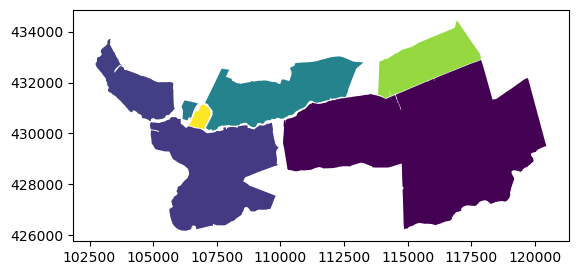

In [14]:
test = to_explode.explode(index_parts=False).reset_index(drop=True)
test['kleur'] = test.index

test['area'] = test.area
test.sort_values(by='area', inplace=True)
test = test.loc[test.area > 1000] #only select the areas which are larger than 1000 m2, as many small parts are created
test.plot(column=test.kleur)

<AxesSubplot:>

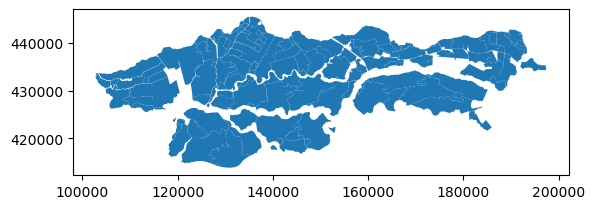

In [15]:
#result look good. Add it to the aggregation areas again
aggregation_area = pd.concat([aggregation_area, test])
aggregation_area = gpd.GeoDataFrame(aggregation_area, geometry = 'geometry')
aggregation_area.plot()

In [16]:
aggregation_area['code'] = aggregation_area['code'].astype(str) + '_dummy_id_' + aggregation_area.index.astype(str)

aggregation_area['nen3610id'] = 'dummy_nen3610id_agg_area_' + aggregation_area.index.astype(str)
aggregation_area['globalid'] = 'dummy_globalid_agg_area_' + aggregation_area.index.astype(str)
aggregation_area = aggregation_area[['code', 'nen3610id', 'globalid', 'geometry']]
WSRL['aggregation_area'] = aggregation_area

### Adjust column names

In [17]:
#add gemaal information
WSRL['peilgebiedpraktijk']['waterhoogte'] = np.nan
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'seizoensgebonden', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'flexibel', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'natuurlijk', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'vast', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['VASTPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[WSRL['peilgebiedpraktijk']['TYPE_PEILBEHEER'] == 'streef', 'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['STREEFPEIL'], inplace=True)

#niet elke kolom is ingevuld met de paren die je zou verwachten. Vul voor de ontbrekende waarden de volgende waarden in:
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['STREEFPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['VASTPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['ZOMERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['MIN_PEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['WINTERPEIL'], inplace=True)
WSRL['peilgebiedpraktijk'].loc[:,'waterhoogte'].fillna(WSRL['peilgebiedpraktijk']['MAX_PEIL'], inplace=True)


In [18]:
#Add gemaal information
#determine aanvoer en afvoer gemalen
WSRL['gemaal']['func_aanvoer'], WSRL['gemaal']['func_afvoer'], WSRL['gemaal']['func_circulatie']  = False, False, False #default is False
WSRL['gemaal']['functiegemaal'] = WSRL['gemaal']['naam'].astype(str) 


WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Afvoer|Onbekend|Af-|Onderbemaling'), 'func_afvoer'] = True
WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Aanvoer|Opmaling'), 'func_aanvoer'] = True
WSRL['gemaal'].loc[WSRL['gemaal'].functiegemaal.str.contains('Doorspoelgemaal'), 'func_circulatie'] = True
WSRL['gemaal'].loc[(WSRL['gemaal'].func_afvoer == False) &
                       (WSRL['gemaal'].func_aanvoer == False) &
                       (WSRL['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [19]:
#discard irrelevant data of WSRL, and create a uniform dataset compared to the other waterschappen
WSRL['stuw'] = WSRL['stuw'][['code', 'globalid', 'nen3610id', 'geometry']]
WSRL['gemaal'] = WSRL['gemaal'][['code', 'globalid', 'nen3610id', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
WSRL['hydroobject'] = WSRL['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]
WSRL['duikersifonhevel'] = WSRL['duikersifonhevel'][['code', 'globalid', 'nen3610id', 'geometry']]


In [20]:
# gpd.overlay(WSRL['peilgebiedpraktijk'], WSRL['peilgebiedafwijking'], how='union', keep_geom_type=False).to_file('WSRL_kan_weg.gpkg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


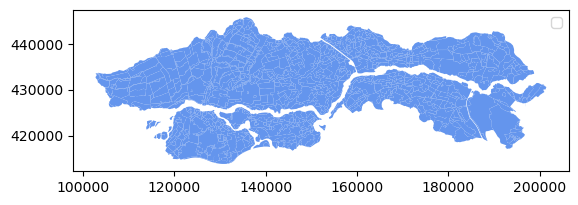

In [21]:
fig, ax = plt.subplots()
WSRL['peilgebiedpraktijk'].plot(ax=ax, color='cornflowerblue', label = 'Peilgebiedpraktijk')
# WSRL['peilgebiedafwijking'].plot(ax=ax, color='blue', label = 'Peilgebiedafwijking')
ax.legend()
plt.show()

In [22]:
def intersect_using_spatial_index(peilgebied_praktijk, peilgebied_afwijking, check):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    peilgebied_praktijk_sindex = peilgebied_praktijk.sindex
    possible_matches_index = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in peilgebied_afwijking.itertuples():
        bounds = other.geometry.bounds
        c = list(peilgebied_praktijk_sindex.intersection(bounds))
        possible_matches_index += c
    
    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = peilgebied_praktijk.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    overlapping_pg_praktijk = possible_matches.loc[possible_matches.intersects(peilgebied_afwijking.unary_union)] #the entire peilgebied praktijk polygons
    
    #remove the peilgebied afwijking from the peilgebied praktijk
    intersection = gpd.overlay(overlapping_pg_praktijk, peilgebied_afwijking, how='intersection')
    overlapping_updated = gpd.overlay(peilgebied_praktijk, intersection, how='symmetric_difference') #check of het difference of symmetrical difference moet zijn!#remove the difference between pg_praktijk and pg_afwijking
    peilgebied = overlapping_updated.append(intersection, ignore_index=True) #add the removed difference, but now only the intersected part of pg_afwijking

    
    if check == True:
        peilgebied_praktijk.to_file('Checks/Rivierenland/peilgebied_praktijk.gpkg', driver='GPKG')
        peilgebied_afwijking.to_file('Checks/Rivierenland/peilgebied_afwijking.gpkg', driver='GPKG')

        intersection.to_file('Checks/Rivierenland/intersection.gpkg', driver='GPKG')
        overlapping_updated.to_file('Checks/Rivierenland/overlapping_updated.gpkg', driver='GPKG')
        peilgebied.to_file('Checks/Rivierenland/peilgebied.gpkg', driver='GPKG')
    
    return peilgebied

In [23]:
# peilgebied = intersect_using_spatial_index(peilgebied_praktijk = WSRL['peilgebiedpraktijk'], 
#                                            peilgebied_afwijking = WSRL['peilgebiedafwijking'],
#                                            check = False)
peilgebied = WSRL['peilgebiedpraktijk']

In [24]:
# WSRL['peilgebiedpraktijk'] = WSRL['peilgebiedpraktijk'][['ZOMERPEIL', 'WINTERPEIL', 'MIN_PEIL', 'MAX_PEIL', 'STREEFPEIL', 'VASTPEIL', 'TYPE_PEILBEHEER', 'geometry']]
# peilgebied['waterhoogte'] = np.nan

# for fill_column in ['ZOMERPEIL', 'STREEFPEIL', 'VASTPEIL', 'MAX_PEIL', 'MIN_PEIL', 'WINTERPEIL']:
#     peilgebied.waterhoogte.fillna(value = peilgebied[fill_column], inplace=True)
                                                  
# WSRL['peilgebiedpraktijk'].waterhoogte.fillna(value=WSRL['peilgebiedpraktijk'][['ZOMERPEIL', 'STREEFPEIL', 'VASTPEIL', 'MAX_PEIL', 'MIN_PEIL']])

<AxesSubplot:>

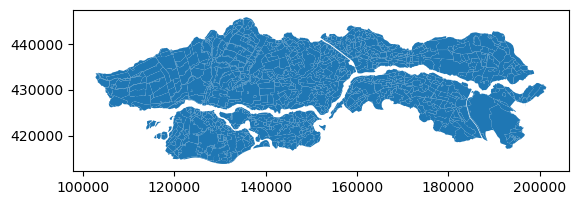

In [25]:
#store the ontbrekende_streefpeilen to a gpkg, check validity
ontbrekende_streefpeilen = peilgebied[peilgebied.waterhoogte.isna()]
# ontbrekende_streefpeilen.to_file('Checks/Rivierenland/peilgebieden_zonder_streefpeil.gpkg', driver='GPKG')
peilgebied.plot()

In [26]:
peilgebied['CODE_0'] = peilgebied.CODE #change names for later purposes
peilgebied.CODE = np.nan

#add and fill the final columns
columns_to_check = ['CODE_0']

for fill_column in ['CODE_0']:
    peilgebied.CODE.fillna(value = peilgebied[fill_column], inplace=True)

peilgebied['globalid'] = peilgebied.index.astype(str)
peilgebied['nen3610id'] = 'dummy_nen3610id_peilgebied_' + peilgebied.index.astype(str)

#create streefpeil key
WSRL['streefpeil'] = peilgebied[['waterhoogte', 'globalid']]
WSRL['streefpeil']['geometry'] = np.nan
WSRL['streefpeil'] = gpd.GeoDataFrame(WSRL['streefpeil'])

#only select the relevant columns
peilgebied = peilgebied[['CODE', 'globalid', 'nen3610id', 'geometry']]
WSRL['peilgebied'] = peilgebied #add to the dict

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_16448\1047803125.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSRL['streefpeil']['geometry'] = np.nan


In [27]:
WSRL['streefpeil'].waterhoogte = WSRL['streefpeil'].waterhoogte.round(2)

In [28]:
#discard irrelvant data
variables = ['peilgebiedpraktijk','peilgebiedafwijking']

for variable in variables:
    if str(variable) in WSRL:
        del WSRL[variable]

In [29]:
#I have splitted a peilgebied manually. Make sure that the peilgebied has an unique code
WSRL['peilgebied'].loc[(WSRL['peilgebied'].CODE == 'LNG014-P') & (WSRL['peilgebied'].nen3610id == 'dummy_nen3610id_peilgebied_1133'), 'CODE'] = 'LNG014-P_extra'

### Check for the correct keys and columns

In [30]:
show_layers_and_columns(waterschap = WSRL)

stuw
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'nen3610id' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

aggregation_area
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  None

peilgebied
['CODE' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992



### Store data

In [31]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = WSRL, 
           output_gpkg_path = output_gpkg_path + '/WSRL')
